# Evaluating the model

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from sklearn.utils import shuffle
from pathlib import Path

In [2]:
!unzip 201403121135.zip

Archive:  201403121135.zip
   creating: 201403121135/
  inflating: 201403121135/image_0000.png  
  inflating: 201403121135/image_0001.png  
  inflating: 201403121135/image_0002.png  
  inflating: 201403121135/image_0003.png  
  inflating: 201403121135/image_0004.png  
  inflating: 201403121135/image_0005.png  
  inflating: 201403121135/image_0006.png  
  inflating: 201403121135/image_0007.png  
  inflating: 201403121135/image_0008.png  
  inflating: 201403121135/image_0009.png  
  inflating: 201403121135/image_0010.png  
  inflating: 201403121135/image_0011.png  
  inflating: 201403121135/image_0012.png  
  inflating: 201403121135/image_0013.png  
  inflating: 201403121135/image_0014.png  
  inflating: 201403121135/image_0015.png  
  inflating: 201403121135/image_0016.png  
  inflating: 201403121135/image_0017.png  
  inflating: 201403121135/image_0018.png  
  inflating: 201403121135/image_0019.png  
  inflating: 201403121135/image_0020.png  
  inflating: 201403121135/image_0021.png  


In [3]:
def load_xy(px, py):
    """ Converts filenames in X to an array of pixels representing image from
    filesnames in X """
    nx = np.array(px, dtype=str)
    # print(nx[0])
    new_x = []
    for path in nx:
        with PIL.Image.open(f"{path}") as img:
            # print(img_fpath)
            # display(img)
            img_data = np.asarray(img, np.float32)

            # Reshape
            img_data = np.reshape(img_data, (240, 320, 1))

            img_data = tf.image.per_image_standardization(img_data)

            new_x.append(img_data)

    ny = np.array(py)
    # print(ny)
    # print(np.array(new_x).size)
    return np.array(new_x), ny

In [17]:
PATH_TO_DATASET_FOLDER = "201403121135" # The folder that will be tested on

PATH_TO_MODEL = "/content/resnet_bs128_lr0.001.h5" # The path to the model weight
# PATH_TO_MODEL = "resnet_bs128_lr0.001.h5"
PATH_TO_LABEL = "/content/labels.txt" # The path to the labels.txt
# PATH_TO_LABEL = "labels.txt"
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH)

In [18]:
print("Creating the Model")
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(256,
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(48,
                                      activation='linear',
                                      name="DenseOutput")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
loss_fn = tf.keras.losses.CosineSimilarity(
    axis=-1, reduction="auto", name="cosine_similarity"
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mae',
  metrics=['mae'])
print("Finished Creating the Model")

Creating the Model
Finished Creating the Model


In [19]:
print("Loading the Model")

model.load_weights(PATH_TO_MODEL)

print("Finished Loading the Model")

Loading the Model
Finished Loading the Model


In [20]:
print("Preprocessing the Test Dataset")

with open(PATH_TO_LABEL, "r") as label:
    labels = [line.strip().split() for line in label]

img_paths = []
targets = []
for label in labels:
    img_path, target = label[0], label[1:]
    base_folder = img_path.split('/')[0]
    if base_folder != PATH_TO_DATASET_FOLDER:
      continue
    img_paths.append(img_path)
    targets.append([float(t) for t in target])

x_test, y_test = load_xy(img_paths, targets)

print("Finished Preprocessing the Test Dataset")

Preprocessing the Test Dataset
Finished Preprocessing the Test Dataset


In [22]:
print("Evaluate the Test Dataset")

results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)


print("Finished Evaluating the Test Dataset")

Evaluate the Test Dataset
84/84 [==============================] - 777s 9s/step - loss: 11.9997 - mae: 11.9997
test loss, test acc: [11.999682426452637, 11.999682426452637]
Finished Evaluating the Test Dataset


Visualizing results

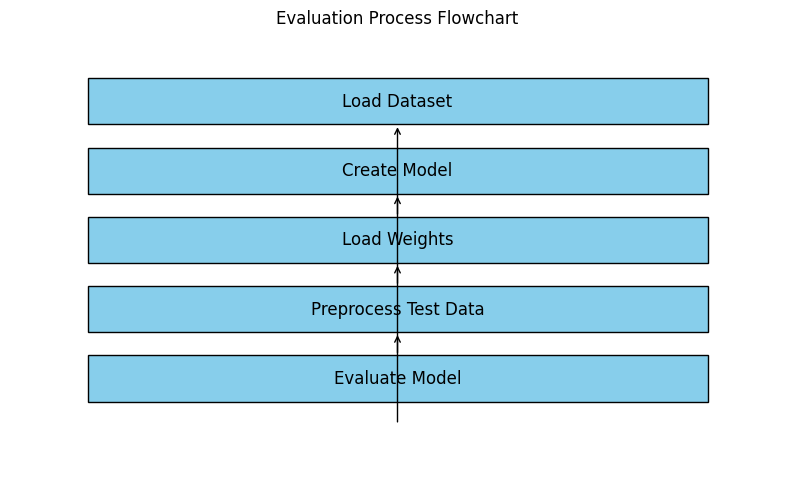

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a flowchart using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# Define rectangles for each step
steps = ['Load Dataset', 'Create Model', 'Load Weights', 'Preprocess Test Data', 'Evaluate Model']

rectangles = []
for i, step in enumerate(steps):
    rect = mpatches.Rectangle((0.1, 0.8 - 0.15 * i), 0.8, 0.1, ec="k", fc="skyblue")
    rectangles.append(rect)
    ax.text(0.5, 0.85 - 0.15 * i, step, ha='center', va='center', fontsize=12)

# Add rectangles to the plot
for rect in rectangles:
    ax.add_patch(rect)

# Add arrows to connect the steps
for i in range(len(rectangles) - 1):
    ax.annotate("", xy=(0.5, 0.8 - 0.15 * i), xytext=(0.5, 0.75 - 0.15 * (i + 1)),
                arrowprops=dict(arrowstyle='->'))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.title('Evaluation Process Flowchart')
plt.show()


84/84 [==============================] - 786s 9s/step


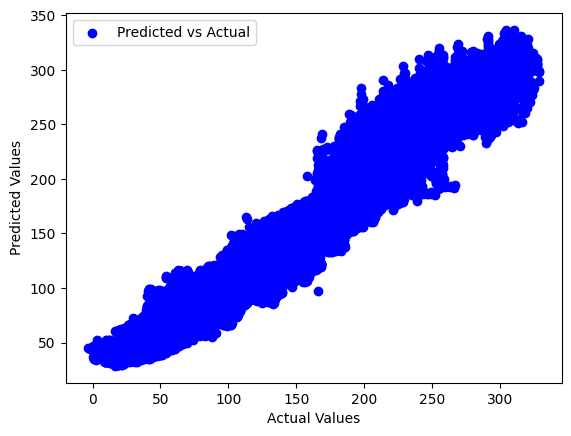

In [25]:
plt.scatter(y_test, model.predict(x_test), label='Predicted vs Actual', color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

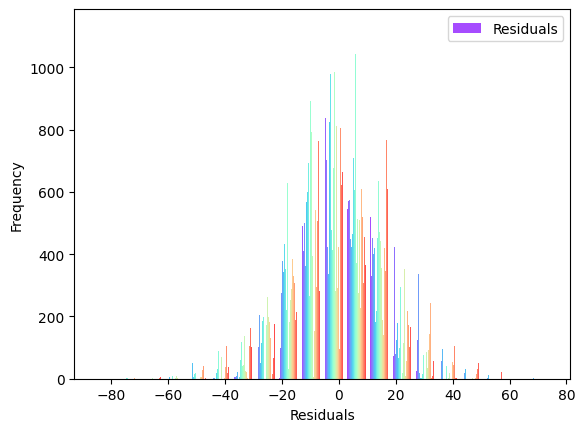

In [27]:
# Assuming you have 48 classes
num_classes = 48

# Generate a list of unique colors for each class
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Plot the histogram for each class with a different color
plt.hist(residuals, bins=20, label='Residuals', color=colors, alpha=0.7)

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [28]:
median_absolute_error = np.median(np.abs(residuals))
std_residuals = np.std(residuals)
print(f"Median Absolute Error: {median_absolute_error}")
print(f"Standard Deviation of Residuals: {std_residuals}")

Median Absolute Error: 9.92608306884766
Standard Deviation of Residuals: 15.30694876771734
